Reading datasets...

Extracting features...

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2817.000000      2817.000000    2817.000000       2817.000000   
mean      1672.781328       371.231807     395.396876        234.624423   
std       4885.438340      8024.052863     465.773534       1446.097189   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1088.000000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2817.000000  2817.000000  2817.000000  
mean       2.819666     1.11217

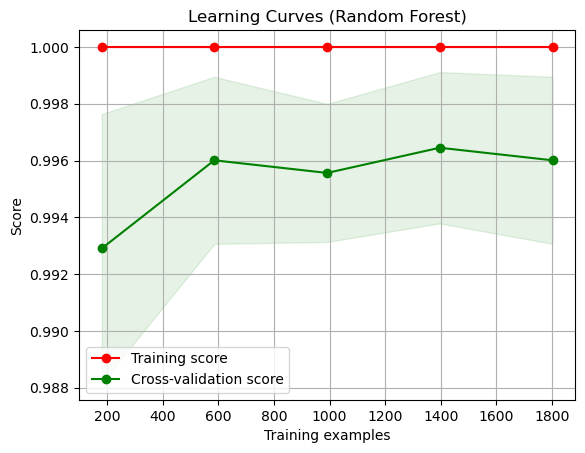

Classification Accuracy on Test dataset:  0.99822695035461
Confusion matrix, without normalization
[[266   1]
 [  0 297]]
Normalized confusion matrix
[[0.99625468 0.00374532]
 [0.         1.        ]]
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       267
     Genuine       1.00      1.00      1.00       297

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564

False Positive rate:  [0.         0.00374532 1.        ]
True Positive rate:  [0. 1. 1.]


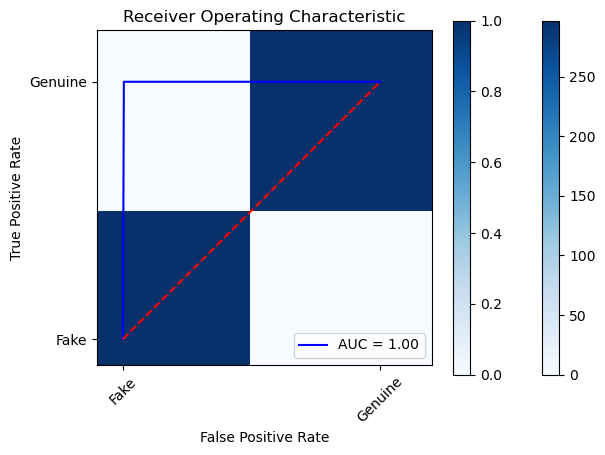

In [6]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve
import gender_guesser.detector as gender

def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    x = pd.concat([genuine_users, fake_users])
    y = [1] * len(genuine_users) + [0] * len(fake_users)
    return x, y

def predict_sex(names):
    sex_predictor = gender.Detector(case_sensitive=False)
    sex_code = []
    for name in names:
        first_name = name.split(' ')[0]
        sex = sex_predictor.get_gender(first_name)
        if sex == 'female':
            sex_code.append(2)
        # elif sex == 'mostly_female':
        #     sex_code.append(-1)
        elif sex == 'male':
            sex_code.append(1)
        # elif sex == 'mostly_male':
        #     sex_code.append(1)
        else:
            sex_code.append(0)  # Assign a default value for unknown genders
    return sex_code

def extract_features(x):
    lang_encoder = LabelEncoder()
    x['lang_code'] = lang_encoder.fit_transform(x['lang'])

    x['sex_code'] = predict_sex(x['name'])

    feature_columns_to_use = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'sex_code', 'lang_code']
    x = x[feature_columns_to_use]
    return x

# Rest of your code...



def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print("False Positive rate: ", false_positive_rate)
    print("True Positive rate: ", true_positive_rate)

    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def train(X_train, y_train, X_test):
    """ Trains and predicts dataset with a Random Forest classifier """
    clf = RandomForestClassifier(n_estimators=40, oob_score=True)
    clf.fit(X_train, y_train)
    print("The best classifier is: ", clf)
    
    # Estimate score
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))

    title = 'Learning Curves (Random Forest)'
    plot_learning_curve(clf, title, X_train, y_train, cv=5)
    plt.show()

    # Predict
    y_pred = clf.predict(X_test)
    import pickle
    with open('data.pkl','wb') as file:
        pickle.dump(clf,file)
    return y_test, y_pred

print("Reading datasets...\n")
x, y = read_datasets()
x.describe()

print("Extracting features...\n")
x = extract_features(x)
print(x.columns)
print(x.describe())

print("Splitting datasets into train and test dataset...\n")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=44)

print("Training datasets...\n")
y_test, y_pred = train(X_train, y_train, X_test)

print('Classification Accuracy on Test dataset: ', accuracy_score(y_test, y_pred))



cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

print(classification_report(y_test, y_pred, target_names=['Fake', 'Genuine']))

plot_roc_curve(y_test, y_pred)

In [7]:
print (X_test)

      statuses_count  followers_count  friends_count  favourites_count  \
512             9950              658            701                18   
630             6991             1001            614              2401   
189             1809              102            392                18   
343              770               42            149                28   
1129              27                7            296                 0   
...              ...              ...            ...               ...   
1264             440               98            770                 2   
78                66               22            581                 0   
273               37               16            445                 0   
588              293               42            139                 0   
761               23               19            310                 0   

      listed_count  sex_code  lang_code  
512             11         2          5  
630              6         